In [2]:
import importlib
import modules
import cellpylib as cpl
import numpy as np
import matplotlib.pyplot as plt
import scipy

importlib.reload(modules)

from modules import run_model_stochastic
from modules import CA


In [5]:
def func(x, a, b):
    return [a * x_i ** -b for x_i in x]

def single_fit(x, y):
    popt1, pcov1 = scipy.optimize.curve_fit(func, x, y, p0=[1, 0.5])
    a1, b1 = popt1

    return a1, b1
        
def double_fit(x, y):
    highest_b2 = 0

    for index in range(int(len(x)*0.2), int(len(x)*0.8)):
        popt1, pcov1 = scipy.optimize.curve_fit(func, x[0:index], y[0:index], p0=[1, 0.5], maxfev=5000)
        a1, b1 = popt1

        popt2, pcov2 = scipy.optimize.curve_fit(func, x[index:], y[index:], p0=[1, 0.5], maxfev=5000)
        a2, b2 = popt2

        if b2 > highest_b2:
            # Find steepest line
            highest_b2 = b2

            best_a1, best_b1, best_a2, best_b2 = a1, b1, a2, b2

            optimal_index = index

    return best_a1, best_b1, best_a2, best_b2, optimal_index

def find_intersection(x_data, a1, b1, a2, b2):
    # Finds the first intersection which will automatically be the point where y1 > y2
    x = np.linspace(1, np.max(x_data), np.max(x_data))
    y1 = func(x, a1, b1)
    y2 = func(x, a2, b2)
    for index in range(len(x)):
        if y1[index] >= y2[index]:
            return x[index]
        
    return None

def plot_fit(x, y, a1, b1, a2, b2):
    plt.clf()
    plt.loglog(x, y, 'o', markersize=2)
    plt.xlim(0, 1.1*np.max(x))
    plt.ylim(0, 1.1*np.max(y))
    plt.loglog(x, func(x, a1, b1))
    plt.loglog(x, func(x, a2, b2))
    plt.show()

def find_critical_size(density_list, n_simulations, L, T, n_repetitions):
    critical_size_dict = {}
    critical_size = None
    for p in density_list:
        for n in range(n_simulations): 
            print(p, n, critical_size)
            lifespan_counter, final_jams_counted = run_model_stochastic(p, L, T, n_repetitions, v_max=5)
            lists = sorted(final_jams_counted.items()) # sorted by key, return a list of tuples

            x_data, y_data = zip(*lists)
            a_optimal1, b_optimal1, a_optimal2, b_optimal2, optimal_index = double_fit(x_data, y_data)

            critical_size = find_intersection(x_data, a_optimal1, b_optimal1, a_optimal2, b_optimal2)

            if critical_size == None:
                # If lines do not intersect skip to the next density
                if p in critical_size_dict:
                    del critical_size_dict[p]        
                break

            else:
                if p not in critical_size_dict:
                    critical_size_dict[p] = [critical_size]
                else:
                    critical_size_dict[p] += [critical_size]

    return critical_size_dict
        

In [7]:
density_list = np.linspace(0.50, 0.75, 5)
n_simulations = 10
L=1000
T=int(L/2)
n_repetitions = 100

critical_size_dict = find_critical_size(density_list, n_simulations, L, T, n_repetitions)

0.5 0 None
0.5 1 1379.0
0.5 2 1283.0
0.5 3 1356.0
0.5 4 1296.0
0.5 5 1380.0
0.5 6 1350.0
0.5 7 1358.0
0.5 8 1359.0
0.5 9 1298.0
0.5625 0 1308.0
0.5625 1 1542.0
0.5625 2 1547.0
0.5625 3 1627.0
0.5625 4 1585.0
0.5625 5 1529.0
0.5625 6 1567.0
0.5625 7 1566.0
0.5625 8 1559.0
0.5625 9 1543.0
0.625 0 1535.0
0.625 1 1736.0
0.625 2 1763.0
0.625 3 1721.0
0.625 4 1834.0
0.625 5 1792.0
0.625 6 1806.0
0.625 7 1786.0
0.625 8 1788.0
0.625 9 1808.0
0.6875 0 1789.0
0.6875 1 1997.0
0.6875 2 2009.0
0.6875 3 2048.0
0.6875 4 2039.0
0.6875 5 2041.0
0.6875 6 2054.0
0.6875 7 2055.0
0.6875 8 1994.0
0.6875 9 2041.0
0.75 0 2040.0
0.75 1 2302.0
0.75 2 2340.0
0.75 3 2386.0
0.75 4 2351.0
0.75 5 2331.0
0.75 6 2317.0
0.75 7 2339.0
0.75 8 2328.0
0.75 9 2351.0


In [8]:
print(critical_size_dict)

{0.5: [1379.0, 1283.0, 1356.0, 1296.0, 1380.0, 1350.0, 1358.0, 1359.0, 1298.0, 1308.0], 0.5625: [1542.0, 1547.0, 1627.0, 1585.0, 1529.0, 1567.0, 1566.0, 1559.0, 1543.0, 1535.0], 0.625: [1736.0, 1763.0, 1721.0, 1834.0, 1792.0, 1806.0, 1786.0, 1788.0, 1808.0, 1789.0], 0.6875: [1997.0, 2009.0, 2048.0, 2039.0, 2041.0, 2054.0, 2055.0, 1994.0, 2041.0, 2040.0], 0.75: [2302.0, 2340.0, 2386.0, 2351.0, 2331.0, 2317.0, 2339.0, 2328.0, 2351.0, 2371.0]}


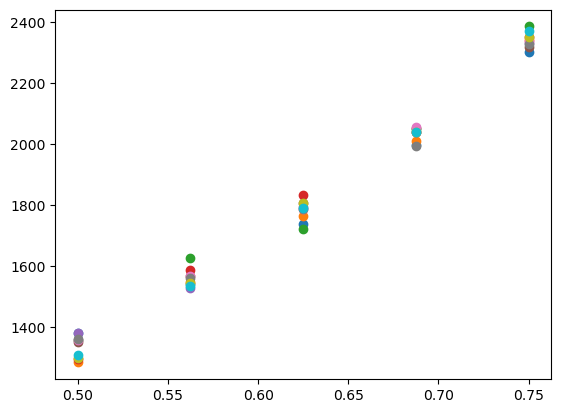

In [10]:
for key in critical_size_dict:
    for value in critical_size_dict[key]:
        plt.plot(key, value,'o',color='red', markersize=1)

In [ ]:
p = 0.6
L = 100
T = 50
n_repetitions = 1000
lifespan_counter, final_jams_counted = run_model_stochastic(p, L, T, n_repetitions, v_max=5)
lists = sorted(final_jams_counted.items()) # sorted by key, return a list of tuples
x_data, y_data = zip(*lists)
plt.loglog(x_data, y_data, 'o', markersize = 2)

def plot_fit_saver(x, y, a1, b1, a2, b2, index):
    plt.clf()
    plt.loglog(x, y, 'o', markersize=2)
    plt.xlim(0, 1.1*np.max(x))
    plt.ylim(0, 1.1*np.max(y))
    plt.loglog(x, func(x, a1, b1))
    plt.loglog(x, func(x, a2, b2))
    plt.savefig(f'Animation/fig{index}.png')

def double_fit_saver(x, y):
    highest_b2 = 0

    for index in range(int(len(x)*0.2), int(len(x)*0.8)):
        popt1, pcov1 = scipy.optimize.curve_fit(func, x[0:index], y[0:index], p0=[1, 0.5], maxfev=5000)
        a1, b1 = popt1

        popt2, pcov2 = scipy.optimize.curve_fit(func, x[index:], y[index:], p0=[1, 0.5], maxfev=5000)
        a2, b2 = popt2

        if b2 > highest_b2:
            # Find steepest line
            highest_b2 = b2

            best_a1, best_b1, best_a2, best_b2 = a1, b1, a2, b2

            optimal_index = index

        plot_fit_saver(x, y, a1, b1, a2, b2, index)   
        
    return best_a1, best_b1, best_a2, best_b2, optimal_index

double_fit_saver(x_data, y_data)

In [ ]:
filenames = [f'Animation/fig{index}.png' for index in range(int(len(x_data)*0.2), int(len(x_data)*0.8))]
print(filenames)


In [ ]:
import imageio
with imageio.get_writer('Animation/critical_size.gif', mode='I') as writer:      #https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
import matplotlib.pyplot as plt
critical_size_dict = {0.55: [1250.0, 1107.0, 1094.0, 1095.0, 1264.0, 1212.0, 1107.0, 1170.0, 1164.0, 1079.0], 0.6000000000000001: [920.0, 908.0, 966.0, 899.0, 923.0, 924.0, 921.0, 891.0, 904.0, 943.0], 0.65: [861.0, 876.0, 884.0, 888.0, 896.0, 852.0, 854.0, 895.0, 906.0, 880.0], 0.7: [861.0, 863.0, 849.0, 881.0, 835.0, 851.0, 815.0, 862.0, 850.0, 870.0], 0.75: [896.0, 938.0, 858.0, 854.0, 824.0, 848.0, 964.0, 860.0, 842.0, 843.0]}

for key in critical_size_dict:
    for value in critical_size_dict[key]:
        plt.plot(float(key), float(value), 'o', color='red')

plt.show()